# Traffic Jam in Kenya

## Summary of the problem

In recent times, the capital city of Kenya, Nairobi, has been experiencing heavy traffic crisis as a result of rapid growth in the number of travellers from a few to thousands each day from neigh-bouring towns for various reasons. To curb the traffic jam situation, accumulated data for the past few months have been made available in order to generate a model that will be used for the predictions of the number of tickets that will be sold for buses into Nairobi from other cites in Kenya.

In [711]:
#Library Importation 
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor,AdaBoostRegressor,BaggingRegressor,ExtraTreesRegressor
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler 

## Reflection on the Data and feature engineering.

### Loading Data

In [712]:
data=pd.read_csv('./dataset/train_revised.csv', low_memory=False)

### Data description

In [713]:
data.describe(include='all')

ride_id seat_number payment_method payment_receipt travel_date  \
count   51645.000000       51645          51645           51645       51645   
unique           NaN          61              2           51645         149   
top              NaN           1          Mpesa      UQ894NMZYR    10-12-17   
freq             NaN        2065          51532               1         856   
mean    10188.645793         NaN            NaN             NaN         NaN   
std      2211.295708         NaN            NaN             NaN         NaN   
min      1442.000000         NaN            NaN             NaN         NaN   
25%      8287.000000         NaN            NaN             NaN         NaN   
50%     10353.000000         NaN            NaN             NaN         NaN   
75%     12029.000000         NaN            NaN             NaN         NaN   
max     20117.000000         NaN            NaN             NaN         NaN   

       travel_time travel_from travel_to car_type  max_capacity  
count        51645       51645     51645    51645  51645.000000  
unique          78          17         1        2           NaN  
top           7:09       Kisii   Nairobi      Bus           NaN  
freq          3926       22607     51645    31985           NaN  
mean           NaN         NaN       NaN      NaN     34.534321  
std            NaN         NaN       NaN      NaN     18.451193  
min            NaN         NaN       NaN      NaN     11.000000  
25%            NaN         NaN       NaN      NaN     11.000000  
50%            NaN         NaN       NaN      NaN     49.000000  
75%            NaN         NaN       NaN      NaN     49.000000  
max            NaN         NaN       NaN      NaN     49.000000

### Types of variables

In [714]:
data.dtypes

ride_id             int64
seat_number        object
payment_method     object
payment_receipt    object
travel_date        object
travel_time        object
travel_from        object
travel_to          object
car_type           object
max_capacity        int64
dtype: object

### Checking for missing data

In [715]:
data.isnull().sum()

ride_id            0
seat_number        0
payment_method     0
payment_receipt    0
travel_date        0
travel_time        0
travel_from        0
travel_to          0
car_type           0
max_capacity       0
dtype: int64

There is no missing data in this dataset

### Target variable construction and dropping columns

In [716]:
#Dictionnary of ride_id [ride_id,value]
ride_group_dict=data.ride_id.value_counts()

The follwing variables are not relevant for this analysis :

<ul>
    <li>ride_id: unique ID of a vehicle on a specific route on a specific day and time. We want a general prediction but not only for a specific vehicle.<br/>
        Especially for this variable, we will remove it later on because the construction of the target variable depends on it.<br/><br/>
    </li>
    <li>seat_number :seat assigned to ticket. This is related to the ticket for a specific vehicle. it is therefore not relevant<br/><br/></li>
    <li>payment_method :Wheter the client pay by Mpesa or Cash does not influence the number of sold ticket<br/><br/></li>
    <li>payment_receipt : this is unique for each ticket, we can never encounter two with the same ID. Therefore it is not relevant to predict the number of ticket<br/><br/></li>
    <li>travel_to : destination of ride. All rides are to Nairobi. it never change, so it is useless for our prediction<br/><br/></li>
</ul>
We are going to drop them.

In [717]:
data_prepo=data.drop(['seat_number', 'payment_method', 'payment_receipt', 'travel_to'], axis=1)

Since those variables are dropped, we have now some duplicated rows and a mess for index of rows.
Let's reorganise the dataset

In [718]:
data_prepo.drop_duplicates(inplace=True)
data_prepo.reset_index(inplace=True,drop=True)

#### Creation of target variable

In [719]:
#Filling the column with 0
data_prepo["number_of_tickets"]= np.zeros(len(data_prepo))

# Using the dictionnary of ride_id to fill the target variable
for i in range(len(data_prepo)):
    ride_id = data_prepo.loc[i]["ride_id"]
    data_prepo.at[i,"number_of_tickets"] = ride_group_dict[ride_id]

### Feature extraction


In [720]:
def hourtrans(x):
    if x[0]=='7':
        return 1
    return 0

def transtravel_from(x):
    if x=='Kisii':
        return 1
    elif x in ['Rongo','Homa']:
        return 2
    return 0

def transmonth(x):
    if x in [11,12,1,2,3,4]:
        return 1
    return 0

#### travel_date

The categorical variable travel_date has 149 unique values and each record contains the year, the month and  the day.
This variable should be splitted because only the month and the day are relevant.

Let's see that by visualizing.

In [721]:
data_prepo['travel_date']=pd.to_datetime(data_prepo['travel_date'],infer_datetime_format=True)
#Extraction of month year
data_prepo['m_y'] = data_prepo['travel_date'].dt.strftime('%Y-%m')

#Extraction of year
data_prepo['year'] = pd.to_numeric(data_prepo['travel_date'].dt.strftime('%Y'))

#Extraction of month
data_prepo['m'] = pd.to_numeric(data_prepo['travel_date'].dt.strftime('%m'))-1

#Extraction of month
data_prepo['m_g'] = data_prepo['m'].apply(transmonth)

#Extraction of day
data_prepo['day'] = pd.to_numeric(data_prepo['travel_date'].dt.strftime('%w'))
#data_prepo['day'] = pd.to_numeric(data_prepo['day'])
#Extraction of day
data_prepo['dm'] = data_prepo['travel_date'].dt.strftime('%d')


fig, axes = plt.subplots(figsize=(20,10),nrows=2, ncols=2)


data_prepo['m'].value_counts().sort_index().plot.bar(title='Travel date(M)',ax=axes[0,0])
data_prepo['day'].value_counts().sort_index().plot.bar(title='Travel date(D)',ax=axes[0,1])
ax_=plt.subplot(212)
data_prepo['m_y'].value_counts().sort_index().plot.bar(title='Travel date(Y-M)',ax=ax_)
plt.show()

We can see from the figure above that most of ticket are sold at the end and the begining of the year.

Therefore, we should keep a special look on the month  for the prediction of number of tickets

#### travel_time

In [722]:
axe=data_prepo['travel_time'].value_counts().plot(kind='bar', ax=None, figsize=(50,30), title='Travel time',fontsize=30)
axe.title.set_size(40)
plt.show()

As we can see it, the hour is very important variable. At 7 by example we have several ticket  for different minutes and the number of ticket is decreasing significantly after or before 7 .

Let's extract the hour alone and time in minutes and we will see which one is producing the best performance

In [723]:
data_prepo['minute_only']=data_prepo["travel_time"].str.split(':').apply(lambda x: int(x[1]))
data_prepo['minutes']=data_prepo["travel_time"].str.split(':').apply(lambda x: int(x[0]) * 60 + int(x[1]))
data_prepo['time_to_hour']=data_prepo["travel_time"].str.split(':').apply(lambda x: int(x[0]) + int(x[1])/60)
data_prepo['hour_only']=data_prepo["travel_time"].str.split(':').apply(lambda x: int(x[0]))
#Hour grouped (7 for peak)
data_prepo['hour']=data_prepo["travel_time"].str.split(':').apply(hourtrans)

In [724]:
axe=data_prepo['hour_only'].value_counts().sort_index().plot(kind='bar', ax=None, figsize=(10,5), title='Travel time(H)',)
axe.title.set_size(10)
plt.show()

Hour grouped

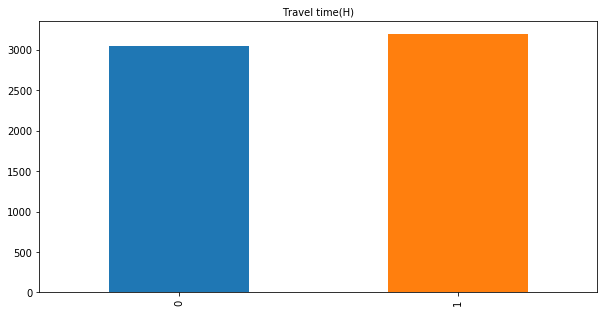

In [725]:
axe=data_prepo['hour'].value_counts().sort_index().plot(kind='bar', ax=None, figsize=(10,5), title='Travel time(H)',)
axe.title.set_size(10)
plt.show()

### Codification of Categorical variables

We have two categorical variables which are : travel_from and car_type.

We should codify them so that we can use them for regression model

#### travel_from

In [726]:
axe=data_prepo['travel_from'].value_counts().plot(kind='bar', ax=None, figsize=(50,30), title='Travel time',fontsize=30)
axe.title.set_size(40)
plt.show()

We can group Kisii, Migori and Homa Bay into one category and all remains in other category

In [727]:
data_prepo.drop(
    data_prepo[data_prepo["travel_from"]=="Keumbu"].index,inplace=True)
data_prepo.drop(
    data_prepo[data_prepo["travel_from"]=="Kendu Bay"].index,inplace=True)
#Keumbu,Kendu Bay 

data_prepo['travel_from_g']=pd.to_numeric(data_prepo['travel_from'].apply(transtravel_from))

data_prepo["travel_from_coded"] = pd.Categorical(data_prepo["travel_from"])
travel_from_categories = data_prepo.travel_from_coded.cat.categories
data_prepo["travel_from_coded"] = data_prepo.travel_from_coded.cat.codes

#### car_type

In [728]:
data_prepo["car_type_coded"] = pd.Categorical(data_prepo["car_type"])
car_type_categories = data_prepo.car_type_coded.cat.categories
data_prepo["car_type_coded"] = data_prepo.car_type_coded.cat.codes

We can  now drop ride_id and additionnal town which are not in test data(Keumbu,Kendu Bay).

In [729]:
#dropping ride_id
data_prepo=data_prepo.drop(['ride_id'], axis=1)

data_prepo.to_csv('train_set_clean.csv', index=False)

In [730]:
data_prepo.drop(['travel_date','travel_time','travel_from','car_type'],axis=1,inplace=True)
data_prepo.head()

max_capacity  number_of_tickets      m_y  year   m  m_g  day  dm  \
0            49                1.0  2017-10  2017   9    0    2  17   
1            49                1.0  2017-11  2017  10    0    0  19   
2            49                1.0  2017-11  2017  10    0    0  26   
3            49                5.0  2017-11  2017  10    0    1  27   
4            49               31.0  2017-11  2017  10    0    1  27   

   minute_only  minutes  time_to_hour  hour_only  hour  travel_from_g  \
0           15      435      7.250000          7     1              0   
1           12      432      7.200000          7     1              0   
2            5      425      7.083333          7     1              0   
3           10      430      7.166667          7     1              0   
4           12      432      7.200000          7     1              0   

   travel_from_coded  car_type_coded  
0                  7               0  
1                  7               0  
2                  3               0  
3                  1               0  
4                  7               0

# Data Exploration

In [731]:
data_prepo.drop(['number_of_tickets'],axis=1).boxplot(figsize=(20,10))
plt.title('box plot dataset')
plt.show()

We can see that there is some outlier espacially for the variable minutes. So the algorithm to choose should be the one which involve such a case

In [732]:
corr = data_prepo.corr()
plt.figure(figsize=(10,10))
sns.heatmap(corr, xticklabels=corr.columns.values, yticklabels=corr.columns.values)
plt.show()

### Algorithm 

As the target variable (number of ticket) is a natural number, we are going to use regression model.
This dataset contains some outliers, so the model to chose should be robust.

Below we will try some model and describe the best one.


### Performance measure

Therefore, good performance means using the attributes $\ x_i\ $ to generate a prediction that is close to  $y_i$.      For a regression problem where  $y_i$  is a real number(natural number for our case), performance is measured in terms like the mean squared error  ($MSE$)  or the mean absolute error  ($MAE$).

We notice that MSE comes out markedly different in magnitude than  $MAE$  and  $RMSE$ (root of MSE). That’s because MSE is in squared units. For that reason, the RMSE and MAE are usually  more usable numbers to calculate. 

We are planning to submit our solution in Zindi competition which use $MAE$ as measure, so we are going to use $MAE$ here as well.

# Prediction model

In [764]:
def pred_split_(X,y,model):
    seed = 120
    #np.random.seed(seed)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2,random_state=seed)
    model_1 = model
    model_1.fit(X_train,y_train)
    nt_1_test_set = model_1.predict(X_test)
    print ("MAE (train test split)",mean_absolute_error(nt_1_test_set,y_test))
    return model_1

def pred_no_split_(X,y,model):
    model = model
    model.fit(X,y)
    pred_train_set = model.predict(X)
    print ('MAE',mean_absolute_error(pred_train_set,y))
    return model

def pred_and_save(X,keys,file_name,model):
    data_test_set_predictions=model.predict(X)
    data_dict = {'ride_id': keys, 'number_of_ticket': data_test_set_predictions}
    df_predictions = pd.DataFrame(data=data_dict)
    df_predictions = df_predictions[['ride_id','number_of_ticket']]
    df_predictions.to_csv('preds_test_set{}.csv'.format(file_name), index=False)
    return df_predictions

def pred_and_save_int(X,keys,file_name,model):
    data_test_set_predictions=model.predict(X)
    data_dict = {'ride_id': keys, 'number_of_ticket': np.rint(data_test_set_predictions)}
    df_predictions = pd.DataFrame(data=data_dict)
    df_predictions = df_predictions[['ride_id','number_of_ticket']]
    df_predictions.to_csv('preds_test_set{}.csv'.format(file_name), index=False)
    return df_predictions


### Loading test data

In [735]:
data_test_set = pd.read_csv('./dataset/test_questions.csv', low_memory=False)

In [736]:

data_test_set['travel_from_g']=pd.to_numeric(data_test_set['travel_from'].apply(transtravel_from))

data_test_set['travel_date']=pd.to_datetime(data_test_set['travel_date'],infer_datetime_format=True)

#Extraction of month year
data_test_set['m_y'] = data_test_set['travel_date'].dt.strftime('%Y-%m')


#Extraction of year
data_test_set['year'] = pd.to_numeric(data_test_set['travel_date'].dt.strftime('%Y'))


#Extraction of month
data_test_set['m'] = pd.to_numeric(data_test_set['travel_date'].dt.strftime('%m'))-1

#Extraction of month group
data_test_set['m_g'] = data_test_set['m'].apply(transmonth)

#Extraction of day
data_test_set['day'] = pd.to_numeric(data_test_set['travel_date'].dt.strftime('%w'))
data_test_set['dm'] = pd.to_numeric(data_test_set['travel_date'].dt.strftime('%d'))

# Time extration
data_test_set['minute_only']=data_test_set["travel_time"].str.split(':').apply(lambda x: int(x[1]))
data_test_set['minutes']=data_test_set["travel_time"].str.split(':').apply(lambda x: int(x[0]) * 60 + int(x[1]))
data_test_set['hour_only']=data_test_set["travel_time"].str.split(':').apply(lambda x: int(x[0]))
data_test_set['hour']=data_test_set["travel_time"].str.split(':').apply(hourtrans)
data_test_set['time_to_hour']=data_test_set["travel_time"].str.split(':').apply(lambda x: int(x[0]) + int(x[1])/60)

#Categorical variable coding
data_test_set["car_type_coded"] = pd.Categorical(data_test_set["car_type"], categories=car_type_categories)
data_test_set["car_type_coded"] = data_test_set.car_type_coded.cat.codes

data_test_set["travel_from_coded"] = pd.Categorical(data_test_set["travel_from"], categories=travel_from_categories)
data_test_set["travel_from_coded"] = data_test_set.travel_from_coded.cat.codes
# Dropping unnecessary variables
keys=data_test_set['ride_id']
data_test_set.drop(['ride_id','travel_date','travel_time','travel_from','travel_to','car_type'],axis=1,inplace=True)
#data_test_set.to_csv('test_set{}.csv'.format('5'), index=False)


In [737]:
data_test_set.head()

max_capacity  travel_from_g      m_y  year  m  m_g  day  dm  minute_only  \
0            49              1  2018-05  2018  4    1    1   7            6   
1            11              1  2018-05  2018  4    1    0   6            8   
2            11              1  2018-05  2018  4    1    5   4            0   
3            11              1  2018-05  2018  4    1    5   4           10   
4            11              1  2018-05  2018  4    1    5   4           20   

   minutes  hour_only  hour  time_to_hour  car_type_coded  travel_from_coded  
0      426          7     0      7.100000               0                  5  
1      668         11     0     11.133333               1                  5  
2      300          5     0      5.000000               1                  5  
3      550          9     0      9.166667               1                  5  
4      560          9     0      9.333333               1                  5

### Building different model

In [738]:
#Initialistion of list of models and df
model=[]
model_=[]
df=[]
df_=[]

#### Random Forest Regressor

Random forests is one of ensemble learning methode using decision trees. It generates its sequence of models by training them on subsets of the data. The subsets are drawn at random from the full training set. One way in which the subset is selected is to randomly sample rows with replacement. The other random element is that the training sets for the individual trees in the random forests ensemble don’t incorporate all the attributes but take a random subset of the attributes also. That why it has an advantage with wide sparse attribute spaces.


This Algorithm give us best result that others in term of $MAE$

<table>
    <tr><th>Algo</th><th>MAE</th><th>MAE(Zindi)</th></tr>
    <tr><td>RandomForestRegressor</td><td>3.52</td><td>3.77</td></tr>
    <tr><td>GradientBoostingRegressor</td><td>3.57</td><td>3.80</td></tr>
    <tr><td>GaussianProcessRegressor</td><td>3.71</td><td>4.01</td></tr>
</table>

RandomForestRegressor give us the best result because on unknown data, MAE is only 3.77.


In [739]:
index=[#'year',
       'm',
       #'m_g',
       'day',
       #'dm',
       #"hour_only",
       #"hour",
       #"minutes_only",
       'minutes',
       "travel_from_coded",
       #'travel_from_g',
       "car_type_coded",
       #'max_capacity'
      ]



X= data_prepo.filter(index, axis=1)
y = data_prepo.number_of_tickets
X_test=data_test_set.filter(index, axis=1)
X.head()

m  day  minutes  travel_from_coded  car_type_coded
0   9    2      435                  7               0
1  10    0      432                  7               0
2  10    0      425                  3               0
3  10    1      430                  1               0
4  10    1      432                  7               0

In [ ]:
RandomForestRegressor(
        n_estimators=50, 
        criterion='mae', 
        max_depth=None,
        min_samples_split=2, 
        min_samples_leaf=4, 
        min_weight_fraction_leaf=0.0,
        max_features='auto', 
        max_leaf_nodes=None, 
        min_impurity_decrease=0.0,
        min_impurity_split=None, 
        bootstrap=True, 
        oob_score=False, 
        n_jobs=None, 
        random_state=None, 
        verbose=0,
        warm_start=False)

In [773]:
from sklearn.ensemble import RandomForestRegressor

#Initialistion of list of models and df
model=[]
model_=[]
df=[]
df_=[]

params={'n_estimators': 350,
 'min_samples_split': 2,
 'min_samples_leaf': 4,
 'max_features': 'auto',
 'max_depth': None,
 'bootstrap': True,
'random_state':85,}

def getmodel():
    kernel = None
    return RandomForestRegressor(**params,n_jobs=-1,criterion='mae')

model_num=2
index=[#'year',
       'm',
       #'m_g',
       'day',
       'dm',
       #"hour_only",
       #"hour",
       #"minute_only",
        'time_to_hour',
       #'minutes',
       "travel_from_coded",
       #'travel_from_g',
       "car_type_coded",
       #'max_capacity'
      ]
X= data_prepo.filter(index, axis=1)
y = data_prepo.number_of_tickets
X_test=data_test_set.filter(index, axis=1)
X.head()

model.append(pred_no_split_(X,y,getmodel()))


X= data_prepo.filter(index, axis=1)
y = data_prepo.number_of_tickets

model_.append(pred_split_(X,y,getmodel()))


df.append(pred_and_save(X_test,keys,model_num,model[len(model)-1]))
df_.append(pred_and_save(X_test,keys,'_%s'%(model_num),model_[len(model_)-1]))

df.append(pred_and_save_int(X_test,keys,"int_%s"%(model_num),model[len(model)-1]))
df_.append(pred_and_save_int(X_test,keys,'int__%s'%(model_num),model_[len(model_)-1]))
#pprint(getmodel().get_params())

MAE 2.480287411689146
MAE (train test split) 3.3156076587938546


In [549]:
df[len(model_)-1].to_csv("./best/preds_test_best.csv", index=False)
df_[len(model_)-1].to_csv("./best/preds_test_best_.csv", index=False)

In [772]:

data_best=pd.read_csv("./best/preds_test_best.csv", low_memory=False)
combine_pred=[data_best]

for i in range(len(df)):
    if i%2!=0 :
        combine_pred.append(df[i].drop(['ride_id'],axis=1))
        combine_pred.append(df_[i].drop(['ride_id'],axis=1))
pd.concat(combine_pred,axis=1,sort=False).head(20)

ride_id  number_of_ticket  number_of_ticket  number_of_ticket
0       247              8.24               6.0               6.0
1       256              5.79               5.0               5.0
2       275              1.76               2.0               2.0
3       285              9.68               8.0               8.0
4       286              9.96               8.0               8.0
5       287              8.10               8.0               9.0
6       288             10.32               8.0               8.0
7       292              6.11               5.0               6.0
8       298              8.70               8.0               8.0
9       302              7.90               8.0               8.0
10      310              6.92               6.0               6.0
11      311              8.25               8.0               8.0
12      329              8.91               9.0               8.0
13      341              8.23               8.0               8.0
14      344              7.95               8.0               8.0
15      358              8.49               8.0               8.0
16      364              4.73               4.0               5.0
17      373              8.50               8.0               8.0
18      374              8.41               7.0               7.0
19      377              9.21               6.0               5.0

In [568]:
from pprint import pprint
from sklearn.model_selection import RandomizedSearchCV

rf = RandomForestRegressor(random_state = 42,criterion='mae')

print('Parameters currently in use:\n')
pprint(rf.get_params())



# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 400, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
pprint(random_grid)
rf_random = RandomizedSearchCV(estimator = rf,
                               param_distributions = random_grid, 
                               n_iter = 100, cv = 3, 
                               verbose=2, 
                               random_state=42,
                               n_jobs = -1)
# Fit the random search model
rf_random.fit(X, y)

Parameters currently in use:

{'bootstrap': True,
 'criterion': 'mae',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 'warn',
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}
{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [100, 133, 166, 200, 233, 266, 300, 333, 366, 400]}
Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  5.9min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed: 29.4min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 62.0min finished


RandomizedSearchCV(cv=3, error_score='raise-deprecating',
          estimator=RandomForestRegressor(bootstrap=True, criterion='mae', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
           oob_score=False, random_state=42, verbose=0, warm_start=False),
          fit_params=None, iid='warn', n_iter=100, n_jobs=-1,
          param_distributions={'n_estimators': [100, 133, 166, 200, 233, 266, 300, 333, 366, 400], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score='warn', scoring=None, verbose=2)

In [569]:
rf_random.best_params_

{'n_estimators': 233,
 'min_samples_split': 2,
 'min_samples_leaf': 2,
 'max_features': 'sqrt',
 'max_depth': 60,
 'bootstrap': True}

#### Gradient Boosting Regressor

In [365]:
from sklearn.ensemble import GradientBoostingRegressor
def getmodel():
    kernel = None
    return GradientBoostingRegressor(
        loss='lad', 
        learning_rate=0.1, 
        n_estimators=20, 
        subsample=1.0, 
        criterion='mae', 
        min_samples_split=2, 
        min_samples_leaf=1, 
        min_weight_fraction_leaf=0.0,
        max_depth=100, 
        min_impurity_decrease=0.0, 
        min_impurity_split=None, 
        init=None, 
        random_state=None, 
        max_features=None, 
        alpha=0.9, verbose=0, 
        max_leaf_nodes=None, 
        warm_start=True, 
        presort='auto', 
        validation_fraction=0.2, 
        n_iter_no_change=None, 
        tol=0.000001)

model_num=1
index=[#'year',
       #'m',
       #'m_g',
       #'day'
       #'dm',
       #"hour_only",
       "hour",
       #"minutes_only",
       'minutes',
       "travel_from_coded",
       #'travel_from_g',
       "car_type_coded",
       'max_capacity'
      ]



X= data_prepo.filter(index, axis=1)
y = data_prepo.number_of_tickets
X_test=data_test_set.filter(index, axis=1)
model.append(pred_no_split_(X,y,getmodel()))
model_.append(pred_split_(X,y,getmodel()))


df.append(pred_and_save(X_test,keys,model_num,model[len(model)-1]))
df_.append(pred_and_save(X_test,keys,'_%s'%(model_num),model_[len(model_)-1]))

df.append(pred_and_save_int(X_test,keys,"int_%s"%(model_num),model[len(model)-1]))
df_.append(pred_and_save_int(X_test,keys,'int__%s'%(model_num),model_[len(model_)-1]))

MAE 3.4993007852007594
MAE (train test split) 3.6885800627271457


#### Gaussian Process Regressor

In [366]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel

def getmodel():
    kernel = None
    return GaussianProcessRegressor(
    kernel=kernel, 
    alpha=1e-10, 
    optimizer='fmin_l_bfgs_b', 
    n_restarts_optimizer=0,
    normalize_y=False, 
    copy_X_train=True, 
    random_state=None)

model_num=3
index=[#'year',
       #'m',
       #'m_g',
       #'day'
       #'dm',
       #"hour_only",
       "hour",
       #"minutes_only",
       'minutes',
       "travel_from_coded",
       #'travel_from_g',
       "car_type_coded",
       'max_capacity'
      ]


X= data_prepo.filter(index, axis=1)
y = data_prepo.number_of_tickets
X_test=data_test_set.filter(index, axis=1)
model.append(pred_no_split_(X,y,getmodel()))
model_.append(pred_split_(X,y,getmodel()))


df.append(pred_and_save(X_test,keys,model_num,model[len(model)-1]))
df_.append(pred_and_save(X_test,keys,'_%s'%(model_num),model_[len(model_)-1]))

df.append(pred_and_save_int(X_test,keys,"int_%s"%(model_num),model[len(model)-1]))
df_.append(pred_and_save_int(X_test,keys,'int__%s'%(model_num),model_[len(model_)-1]))

MAE 3.6309914645550263
MAE (train test split) 3.846597806982635
